In [0]:
!pip install -q keras
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from IPython.display import SVG, clear_output
from keras.utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from sklearn import preprocessing

In [25]:
from google.colab import auth
from googleapiclient.discovery import build
import io , requests, os
import sys
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = 'regression_model_FL002.h5'

In [0]:


# read training data - It is the aircraft engine run-to-failure data.
file_id = '1Zp92NuIesV8sc6ltbgMTjarqA7WF-Uma'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':file_id}) # replace the id with id of file you want to access
downloaded.GetContentFile('xyz.csv')  
train_df = pd.read_csv('xyz.csv', sep=" ", header=None)
#print(train_df)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
file_id = '18M5OdzXwG5MgDLAXsyjjTnOQ6LSqE5Na'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':file_id}) # replace the id with id of file you want to access
downloaded.GetContentFile('xyz.csv')  
test_df = pd.read_csv('xyz.csv', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
file_id = '1udq2f34_xfVd6DImdX_RFuiQ3KynPRpv'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':file_id}) # replace the id with id of file you want to access
downloaded.GetContentFile('xyz.csv')  
truth_df = pd.read_csv('xyz.csv', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [0]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)


# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

In [29]:
#@title Default title text
# MinMax normalization
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)


   id  cycle  setting1  setting2  setting3        s1        s2        s3  \
0   1      1  0.238019  0.297150       1.0  0.597937  0.637673  0.686550   
1   1      2  0.476162  0.831354       1.0  0.626985  0.663272  0.643289   
2   1      3  0.833282  0.997625       1.0  0.060269  0.187815  0.312475   
3   1      4  0.999967  0.998812       1.0  0.000000  0.134324  0.287038   
4   1      5  0.595089  0.737886       0.0  0.238089  0.010918  0.025599   

         s4        s5     ...           s13       s14       s15  s16  \
0  0.676888  0.617180     ...      0.993662  0.632503  0.114199  1.0   
1  0.535166  0.507937     ...      0.993496  0.487219  0.331283  0.0   
2  0.251745  0.146592     ...      0.992477  0.487171  0.370350  0.0   
3  0.250614  0.000000     ...      0.992394  0.520160  0.388254  0.0   
4  0.064796  0.293184     ...      0.001213  0.041177  0.927248  0.0   

        s17       s18  s19       s20       s21  cycle_norm  
0  0.687500  0.854123  1.0  0.625514  0.633951   

In [0]:
# pick a large window size of 50 cycles
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):
   
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 from row 0 to row 50
    # 1 51 from row 1 to row 51
    # 2 52 from row 2 to row 52
    # ...
    # 111 191 from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]
        

In [31]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to np array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

99
(40759, 50, 25)


In [32]:
# generate labels
def gen_labels(id_df, seq_length, label):
   
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


(40759, 1)

In [0]:
def r2_keras(y_true, y_pred):
   
    res =  K.sum(K.square( y_true - y_pred ))
    tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - res/(tot + K.epsilon()) )


In [0]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.normalization import BatchNormalization

In [38]:
# Next, we build a deep network. 
# The first layer ==> LSTM layer with 100 units
# Second Layer ==>  LSTM layer with 50 units. 
# Dropout is applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and Relu activation.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(Conv1D(filters=25, kernel_size=3, padding='same', activation='relu',
                 input_shape=(sequence_length, nb_features)))

model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))


model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mae',r2_keras])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 50, 25)            1900      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 25)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 100)           80400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                30200     
__________

In [0]:
# plot
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []        
        self.fig = plt.figure()        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, np.sqrt(self.losses), label="loss")
        plt.plot(self.x, np.sqrt(self.val_losses), label="val_loss")
        plt.ylabel('loss - RMSE')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')
        plt.title('model loss = ' + str(min(np.sqrt(self.val_losses))))
        plt.show();
        
plot_losses = PlotLosses()

In [41]:
# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          
                   )

# list all data in history
print(history.history.keys())

#history.save('lstm_rul.h5') 

Train on 38721 samples, validate on 2038 samples
Epoch 1/100
 - 113s - loss: 3233.4281 - mean_absolute_error: 45.9815 - r2_keras: -1.5614e-02 - val_loss: 5242.7167 - val_mean_absolute_error: 57.4075 - val_r2_keras: -1.1591e+00
Epoch 2/100
 - 113s - loss: 3235.8985 - mean_absolute_error: 45.9918 - r2_keras: -1.5820e-02 - val_loss: 5244.9271 - val_mean_absolute_error: 57.4083 - val_r2_keras: -1.1571e+00
Epoch 3/100
 - 114s - loss: 3235.3336 - mean_absolute_error: 45.9826 - r2_keras: -1.5504e-02 - val_loss: 5241.5907 - val_mean_absolute_error: 57.4072 - val_r2_keras: -1.1601e+00
Epoch 4/100
 - 113s - loss: 3239.4614 - mean_absolute_error: 46.0121 - r2_keras: -1.7607e-02 - val_loss: 5243.0290 - val_mean_absolute_error: 57.4077 - val_r2_keras: -1.1588e+00
Epoch 5/100
 - 113s - loss: 3237.7576 - mean_absolute_error: 45.9838 - r2_keras: -1.6474e-02 - val_loss: 5241.2288 - val_mean_absolute_error: 57.4070 - val_r2_keras: -1.1605e+00
Epoch 6/100
 - 109s - loss: 3232.6818 - mean_absolute_error: 

KeyboardInterrupt: ignored

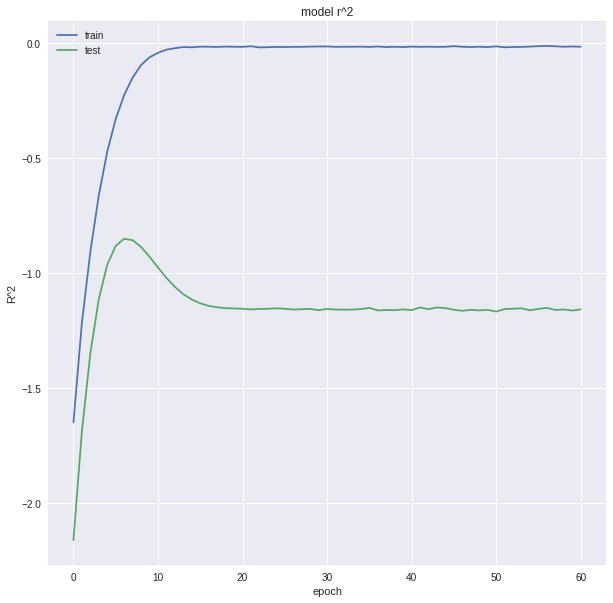

In [15]:
# summarize for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

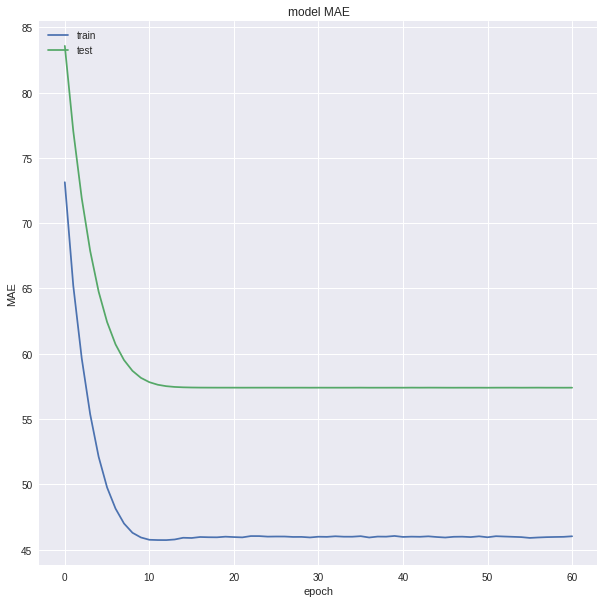

In [16]:

# summarize for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

[11656.841819823081, 10285.663200835133, 9169.628625063011, 8259.920541929894, 7527.096575586321, 6948.257919356446, 6494.097280695113, 6147.185044937209, 5883.323148029242, 5688.287879412261, 5546.9204882620825, 5445.109392969133, 5375.104691525086, 5325.681787013539, 5294.743451568634, 5273.737181059862, 5260.653667236567, 5253.530531234666, 5249.435498957311, 5247.96299700227, 5246.580712076025, 5243.3948010265885, 5245.333330777723, 5246.574082184587, 5248.697050953754, 5246.342517557041, 5242.801936066303, 5244.327236606047, 5245.76704048853, 5239.885979859237, 5245.573792282568, 5242.788999727827, 5242.121454570198, 5242.70278765947, 5244.941782403858, 5250.919403405606, 5238.556277888095, 5240.498163794161, 5239.660055622853, 5243.574769324246, 5239.771759422534, 5252.857711777018, 5244.665575261439, 5252.759189175203, 5249.378426593934, 5241.672108359145, 5236.849103843382, 5241.608777945597, 5238.734275810384, 5241.210956667075, 5233.100461351509, 5245.1368759200195, 5246.7224

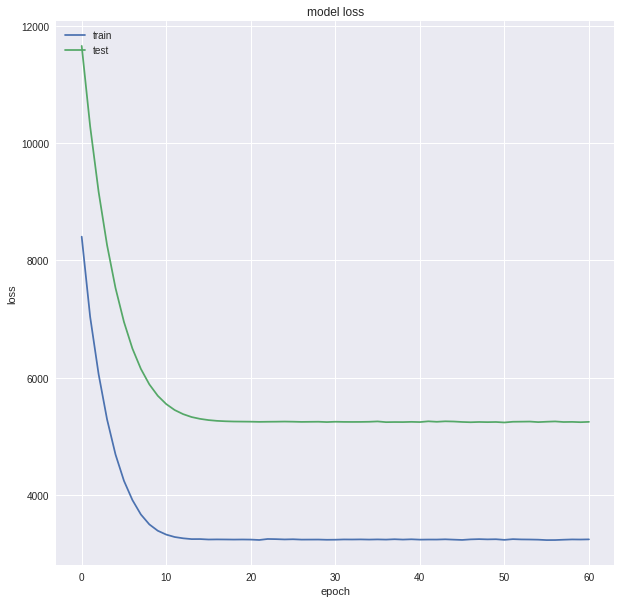

In [17]:
# summarize for Loss
print(history.history['val_loss'])
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")


In [18]:

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

40759/40759 [==============================] - 13s 325us/step

MAE: 46.3573705699

R^2: -0.233266502348


In [19]:

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

40759/40759 [==============================] - 13s 326us/step

MAE: 46.3573705699

R^2: -0.233266502348


In [20]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array
submit = np.concatenate((y_pred, y_true), axis=1)
print(submit)

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)


40759/40759 [==============================] - 13s 326us/step
[[83.67866 98.     ]
 [83.67866 97.     ]
 [83.67866 96.     ]
 ...
 [83.67866  2.     ]
 [83.67866  1.     ]
 [83.67866  0.     ]]


In [21]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)


(235, 1)


In [0]:
def score_cal(y_hat, Y_test):
    d   = y_hat - Y_test
    tmp = np.zeros(d.shape[0])
    for i in range(d.shape[0]):
        if d[i,0] >= 0:
           tmp[i] = np.exp( d[i,0]/10) - 1
        else:
           tmp[i] = np.exp(-d[i,0]/13) - 1
    return tmp 


MAE: 44.4785604761

R^2: -0.0572826035479
[[ 18.       84.01126]
 [ 79.       84.01126]
 [106.       84.01126]
 [110.       84.01126]
 [ 15.       84.01126]
 [155.       84.01126]
 [  6.       84.01126]
 [ 90.       84.01126]
 [ 11.       84.01126]
 [ 79.       84.01126]
 [  6.       84.01126]
 [ 73.       84.01126]
 [ 30.       84.01126]
 [ 11.       84.01126]
 [ 37.       84.01126]
 [ 67.       84.01126]
 [ 68.       84.01126]
 [ 22.       84.01126]
 [ 54.       84.01126]
 [ 97.       84.01126]
 [ 10.       84.01126]
 [ 77.       84.01126]
 [ 88.       84.01126]
 [163.       84.01126]
 [126.       84.01126]
 [ 83.       84.01126]
 [ 78.       84.01126]
 [ 75.       84.01126]
 [ 11.       84.01126]
 [ 53.       84.01126]
 [173.       84.01126]
 [ 63.       84.01126]
 [100.       84.01126]
 [ 55.       84.01126]
 [ 48.       84.01126]
 [ 37.       84.01126]
 [ 44.       84.01126]
 [ 27.       84.01126]
 [ 18.       84.01126]
 [  6.       84.01126]
 [ 15.       84.01126]
 [112.       8

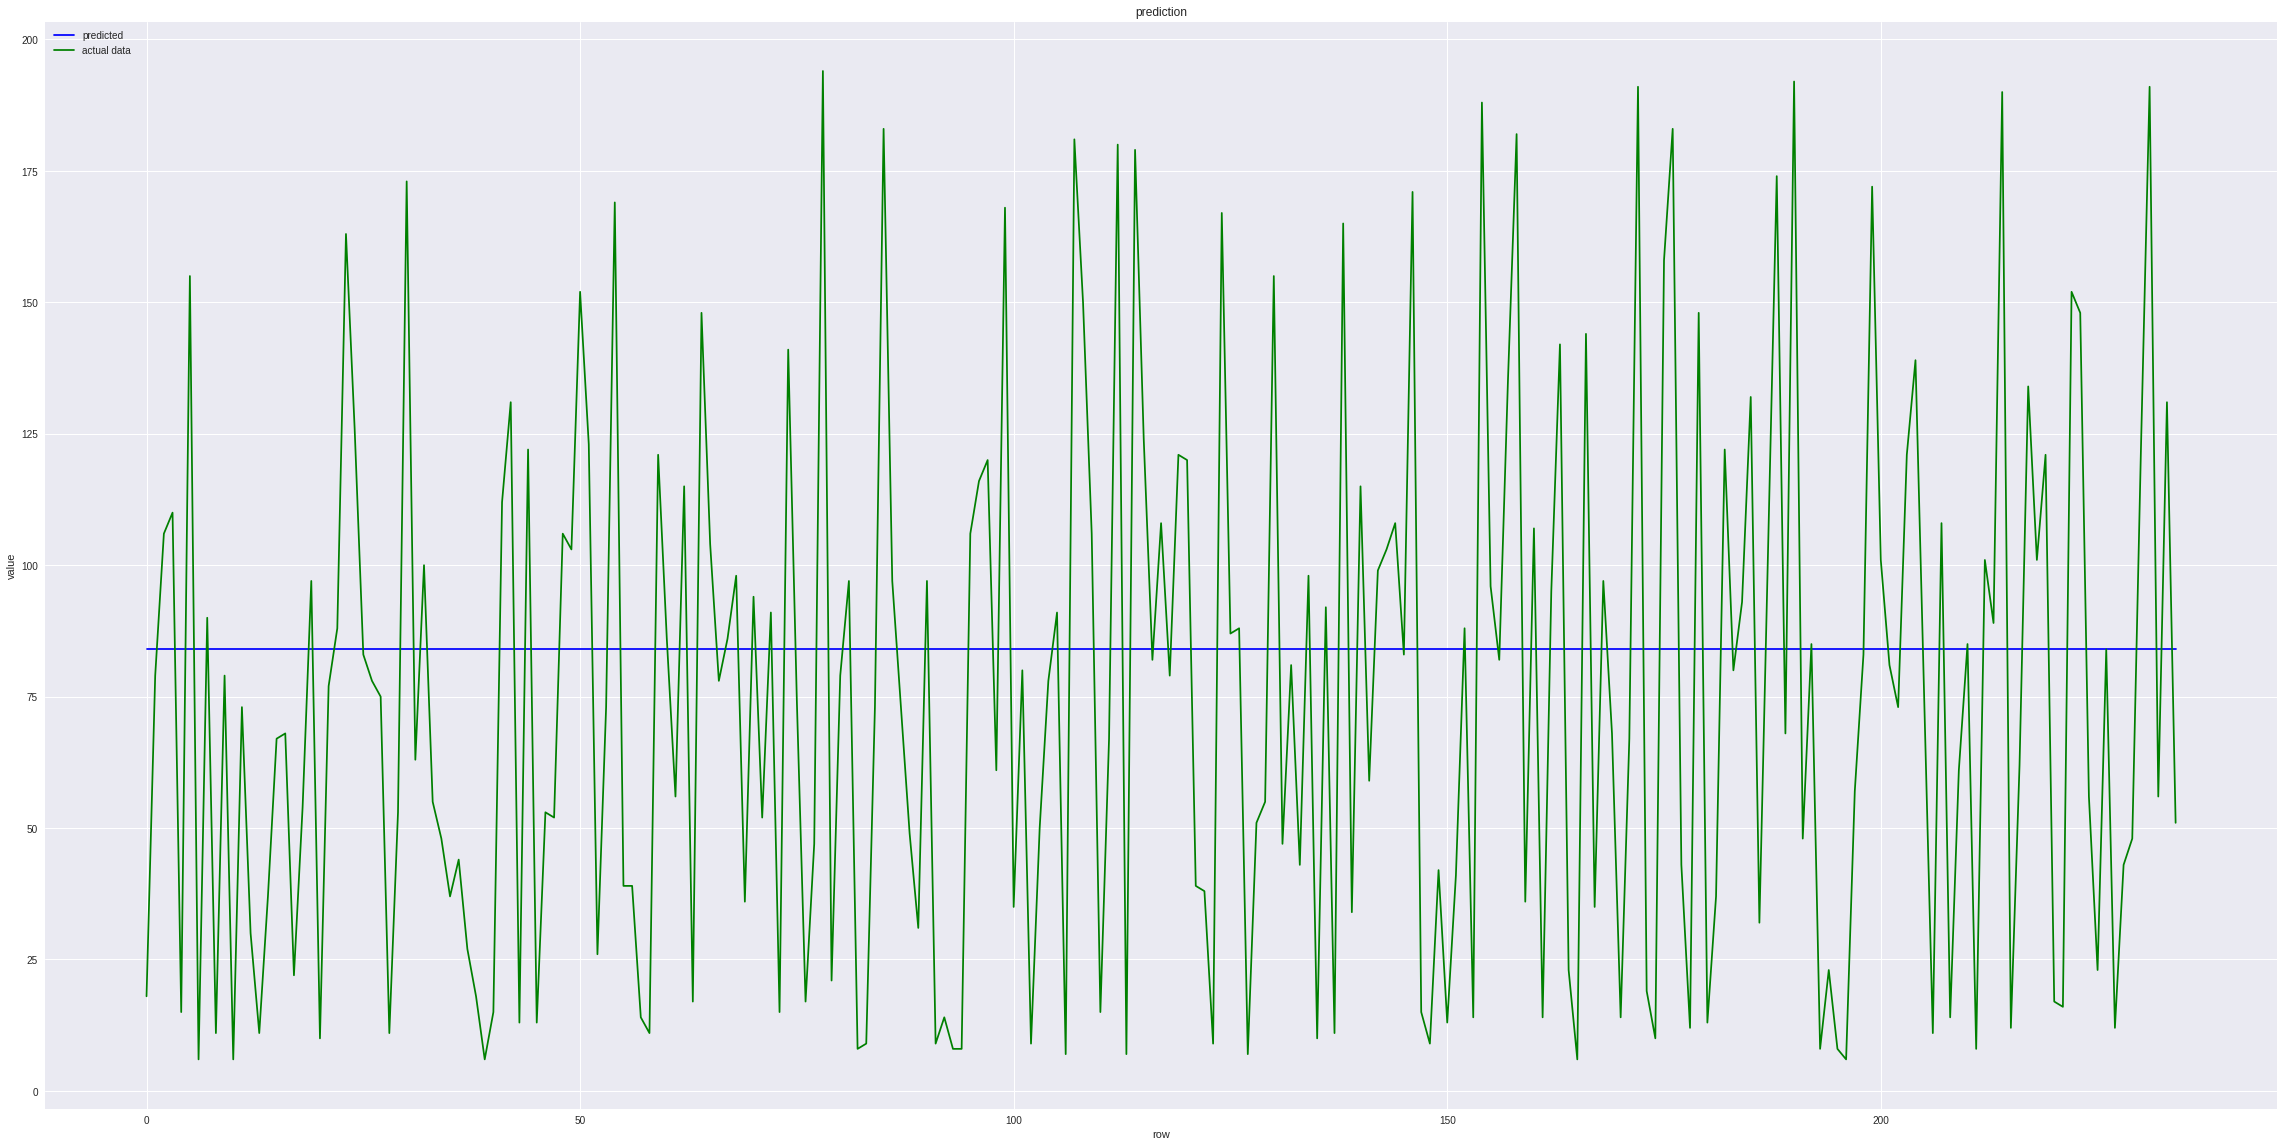

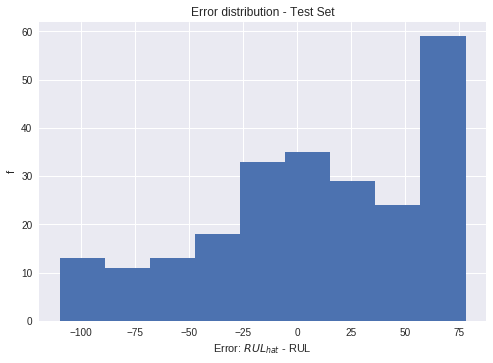

Score = 128039.1801121633


In [23]:
# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    submit = np.concatenate((y_true_test, y_pred_test), axis=1)
    print(submit)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(40, 20))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")
    
    d = y_pred_test - y_true_test
    plt.hist(d, bins='auto')  
    plt.title('Error distribution - Test Set')
    plt.ylabel('f')
    plt.xlabel("Error: $RUL_{hat}$ - RUL")
    plt.show()
    
    score_i_tr = score_cal(y_pred_test, y_true_test)
    print("Score = " + str(sum(score_i_tr)))